Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Carga de Datos

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

# Preprocesamiento y selección de características
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from boruta import BorutaPy

# División de datos y validación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Métricas
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Modelos avanzados
from xgboost import XGBClassifier
import lightgbm as lgb

# Sobremuestreo y submuestreo
from imblearn.under_sampling import EditedNearestNeighbours

# Optimización de hiperparámetros
from skopt import BayesSearchCV


In [2]:
# Carga de Archivos raw para preprocesamiento
raw_contract = pd.read_csv('../raw/contract.csv')
raw_internet = pd.read_csv('../raw/internet.csv')
raw_personal = pd.read_csv('../raw/personal.csv')
raw_phone = pd.read_csv('../raw/phone.csv')

### Analisis  Exploratorio

#### Contract

In [3]:
# Revisamos la info de Contract
raw_contract.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
# Vistazo a los datos.
raw_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
# Revisamos si tenemos duplicados 
raw_contract.duplicated().value_counts()

False    7043
Name: count, dtype: int64

In [6]:
# Revisamos las diferentes alternativas de 'PaymentMethod'
raw_contract['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [7]:
# Revisamos los diferentes alternativas de Type
raw_contract['Type'].value_counts()

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

#### Internet

In [8]:
# Revisamos la info de Internet
raw_internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
# Revisamos los datos de interent
raw_internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
231,5583-SXDAG,Fiber optic,No,No,No,No,No,No
2890,7159-FVYPK,DSL,No,Yes,Yes,No,Yes,No
446,4676-MQUEA,Fiber optic,Yes,Yes,Yes,No,Yes,No
1045,0201-OAMXR,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4346,9572-MTILT,Fiber optic,Yes,Yes,Yes,Yes,Yes,No
2565,3318-OSATS,Fiber optic,No,No,No,No,Yes,Yes
2017,3227-WLKLI,DSL,Yes,Yes,Yes,Yes,Yes,Yes
5209,3588-WSTTJ,Fiber optic,Yes,No,No,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
1753,3496-LFSZU,Fiber optic,No,No,No,No,No,No


In [10]:
# Revisamos los duplicados de internet
raw_internet.duplicated().value_counts()

False    5517
Name: count, dtype: int64

In [11]:
# Revisamos las alternativas de 'InternetService
raw_internet['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

#### Personal

In [12]:
# Vistazo a la info de Personal
raw_personal.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
# Revisamos los datos de Personal
raw_personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
833,2672-TGEFF,Female,0,Yes,Yes
1647,5442-XSDCW,Male,0,Yes,Yes
4289,2228-BZDEE,Female,0,No,No
6869,5906-CVLHP,Female,0,Yes,Yes
3375,3642-BYHDO,Female,0,Yes,Yes
5367,9227-YBAXE,Female,0,Yes,Yes
70,2273-QCKXA,Male,0,No,No
6806,4933-BSAIP,Female,0,Yes,No
4532,2154-KVJFF,Female,0,No,No
3219,3896-ZVNET,Female,0,Yes,Yes


In [14]:
# Revisamos si tenemos duplicados
raw_personal.duplicated().value_counts()

False    7043
Name: count, dtype: int64

#### Phone

In [15]:
# Revisamos la info de Phone
raw_phone.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
# Revisamos los datos de Phone
raw_phone.sample(10)

,customerID,MultipleLines
1083,1579-KLYDT,Yes
6346,2823-LKABH,Yes
1743,7188-CBBBA,Yes
5890,5708-EVONK,Yes
3936,6992-TKNYO,Yes
2746,1498-NHTLT,No
5180,5602-BVFMK,No
1220,0536-BGFMZ,No
3123,0428-AXXLJ,No
5386,4192-GORJT,No


In [17]:
# Revisamos los duplicados de phone
raw_phone.duplicated().value_counts()

False    6361
Name: count, dtype: int64

### Preprocesamiento de datos

In [18]:
# Revisamos los datos de raw_contract
raw_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [19]:
# Verificamos si tenemos valores null
raw_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [20]:
# Conversion de tipo de datos para raw_contract:

# Primero crearemos una nueva columna para 'EndDate_Target' que tengas las clases definidas  0 y 1, 1 significara cancelado y 0 significara activo.

raw_contract['EndDate_Target'] = (raw_contract['EndDate'] != 'No').astype(int)

raw_contract = raw_contract.drop(['EndDate'], axis=1)

raw_contract['TotalCharges'] = pd.to_numeric(raw_contract['TotalCharges'], errors='coerce')

raw_contract['BeginDate'] = pd.to_datetime(raw_contract['BeginDate'])

raw_contract['PaperlessBilling'] = (raw_contract['PaperlessBilling'] == 'Yes').astype(int)

raw_contract[['Type','PaymentMethod']] = raw_contract[['Type','PaymentMethod']].astype('category')

raw_contract['TotalCharges'] = raw_contract['TotalCharges'].fillna(raw_contract['TotalCharges'].median())

raw_contract['Type'] = raw_contract['Type'].astype('object')

raw_contract.loc[raw_contract['Type'] == 'Month-to-month', 'Type'] = 1

raw_contract.loc[raw_contract['Type'] == 'One year', 'Type'] = 12

raw_contract.loc[raw_contract['Type'] == 'Two year', 'Type'] = 24

raw_contract['Type'] = raw_contract['Type'].astype('int')

In [21]:
# Revisamos la info de raw_contract
raw_contract.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Type              7043 non-null   int64         
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   EndDate_Target    7043 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 392.4+ KB


In [22]:
# Revisamos la info de raw_personal
raw_personal.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
# Convertirmos los tipos de dato de raw_personal

raw_personal['gender'] = raw_personal['gender'].astype('category')

raw_personal['Partner'] = (raw_personal['Partner'] == 'Yes').astype(int)

raw_personal['Dependents'] = (raw_personal['Dependents'] == 'Yes').astype(int)

In [24]:
# Revisamos la info de raw_personal
raw_personal.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   int64   
 3   Partner        7043 non-null   int64   
 4   Dependents     7043 non-null   int64   
dtypes: category(1), int64(3), object(1)
memory usage: 227.2+ KB


In [25]:
# Cambiar los tipos de datos de raw_internet

raw_internet['InternetService'] = raw_internet['InternetService'].astype('category')

raw_internet['OnlineSecurity'] = (raw_internet['OnlineSecurity'] ==True).astype(int)

raw_internet['OnlineBackup'] = (raw_internet['OnlineBackup'] ==True).astype(int)

raw_internet['DeviceProtection'] = (raw_internet['DeviceProtection'] ==True).astype(int)

raw_internet['TechSupport'] = (raw_internet['TechSupport'] ==True).astype(int)

raw_internet['StreamingTV'] = (raw_internet['StreamingTV'] ==True).astype(int)

raw_internet['StreamingMovies'] = (raw_internet['StreamingMovies'] ==True).astype(int)

In [26]:
# Revisamos la info de raw_internet
raw_internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   int64   
 3   OnlineBackup      5517 non-null   int64   
 4   DeviceProtection  5517 non-null   int64   
 5   TechSupport       5517 non-null   int64   
 6   StreamingTV       5517 non-null   int64   
 7   StreamingMovies   5517 non-null   int64   
dtypes: category(1), int64(6), object(1)
memory usage: 307.3+ KB


In [27]:
# Convertimos el tipo de dato para raw_phone

raw_phone['MultipleLines'] = (raw_phone['MultipleLines'] == 'Yes').astype(int)

In [28]:
# Revisamos la info de raw_phone
raw_phone.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [29]:
# Cambiaremos a dataframe con iniciales df para cada dataframe
df_contract = raw_contract
df_personal = raw_personal
df_internet = raw_internet
df_phone = raw_phone

In [30]:
# Haremos un merge de todos las columnas para identificar con el modelo Boruta cuales son relevantes
df_merged = df_contract.merge(df_personal, on='customerID').merge(df_phone, on='customerID', how='left').merge(df_internet, on='customerID', how='left')
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Type              7043 non-null   int64         
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   EndDate_Target    7043 non-null   int64         
 8   gender            7043 non-null   category      
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  MultipleLines     6361 non-null   float64       
 13  InternetService   5517 non-null   category      
 14  OnlineSecurity    5517 n

In [31]:
#Revisamos alternativas de df_merged ya que son valores ordinales y lo reemplazaremos por valores numericos que representen su ordinalidad
df_merged['Type'].value_counts()

Type
1     3875
24    1695
12    1473
Name: count, dtype: int64

In [32]:
# Rellenamos valores faltantes:

# Rellenamos valores con 0 para los de fitpo float ya que son numericos y la alternativa 0 signifca que no cuentan con ese servicio.
df_merged[df_merged.select_dtypes('float64').columns] = df_merged.select_dtypes('float64').fillna(0)

# Rellenamos las variables categoricas con 'Ninguno'
df_merged['InternetService'] = df_merged['InternetService'].cat.add_categories('Ninguno')
df_merged['InternetService'] = df_merged['InternetService'].fillna('Ninguno')

# Dataframe unido de todas las columnas
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Type              7043 non-null   int64         
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   EndDate_Target    7043 non-null   int64         
 8   gender            7043 non-null   category      
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  MultipleLines     7043 non-null   float64       
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    7043 n

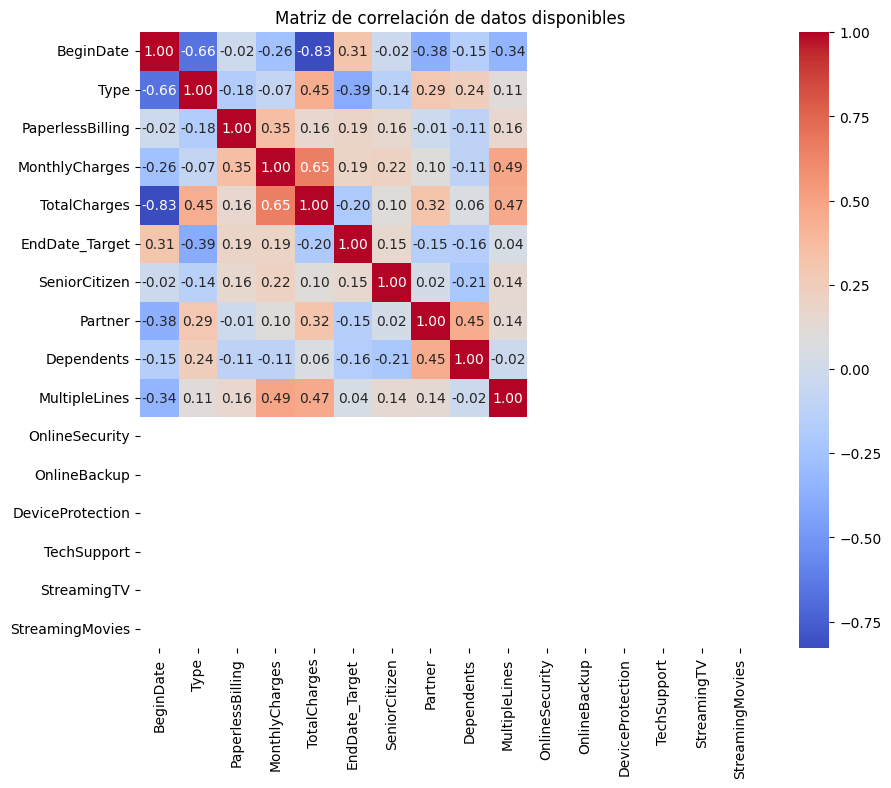

In [33]:
# Calcular la matriz de correlación, ignorando valores nulos
correlation_matrix = df_merged.select_dtypes(exclude=['category','object']).corr()

# Graficar la matriz de correlación con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de correlación de datos disponibles")
plt.show()

### Ingenieria de Caracteristicas

In [34]:
# Aseguramos de aplicar OneHotEncoder a todas las variables categóricas
categorical_columns = ['PaymentMethod', 'gender', 'InternetService']

# Inicializamos OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicamos OneHotEncoder a las columnas categóricas
df_encoded = pd.DataFrame(encoder.fit_transform(df_merged[categorical_columns]))

# El índice debe mantenerse consistente con el DataFrame original
df_encoded.columns = encoder.get_feature_names_out(categorical_columns)
df_encoded.index = df_merged.index

# Unimos el DataFrame codificado con el resto de las características
df_merged = pd.concat([df_merged.drop(columns=categorical_columns), df_encoded], axis=1)

# Reemplazar espacios en df_merged
df_merged.columns = df_merged.columns.str.replace(' ', '_')

# Separamos en características (features) y objetivo (target)
features = df_merged.drop(columns=['EndDate_Target', 'customerID', 'BeginDate'])  # Excluimos columnas no útiles como 'customerID' y 'BeginDate'
target = df_merged['EndDate_Target']

# Dividimos los datos en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

print("Caracteristicas de Entrenamiento", features_train.shape)
print("Caracteristicas de Prueba", features_test.shape)
# tabla

Caracteristicas de Entrenamiento (5282, 20)
Caracteristicas de Prueba (1761, 20)


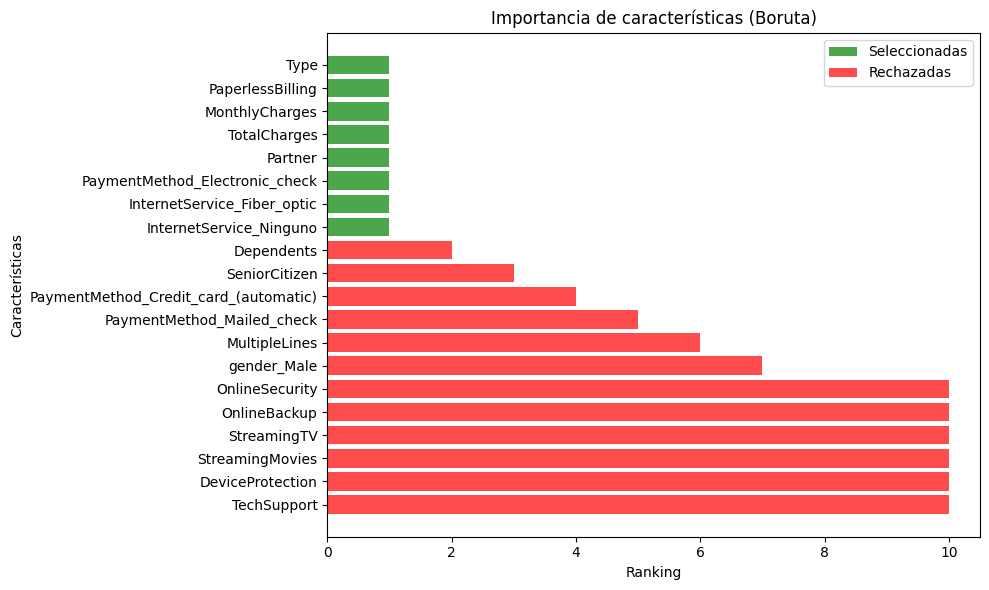

In [35]:
# Ingenieria de Caracteristicas, usamos un algoritmo clasificados para encontrar o definir las columnas que son relevantes para predecir o calcular la columna objetivo.

# Creamos un clasificador RandomForest
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=42)

# Inicializamos Boruta
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)

# Ajustamos Boruta
boruta.fit(features_train.values, target_train.values)  # Usamos los datos de entrenamiento

# Vemos las características seleccionadas por Boruta
selected_features = features.columns[boruta.support_]

# Vemos las características rechazadas por Boruta
rejected_features = features.columns[boruta.support_ == False]

# Ver la importancia de las características
importances = boruta.ranking_

# Convertimos las importancias y rankings en un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': boruta.ranking_,
    'Selected': boruta.support_
})

# Ordenamos por el ranking
importance_df = importance_df.sort_values(by='Ranking')

# Dividimos las características seleccionadas y rechazadas
selected = importance_df[importance_df['Selected'] == True]
rejected = importance_df[importance_df['Selected'] == False]

# Gráfico de barras para características seleccionadas
plt.figure(figsize=(10, 6))
plt.barh(selected['Feature'], selected['Ranking'], color='green', alpha=0.7, label='Seleccionadas')
plt.barh(rejected['Feature'], rejected['Ranking'], color='red', alpha=0.7, label='Rechazadas')
plt.xlabel('Ranking')
plt.ylabel('Características')
plt.title('Importancia de características (Boruta)')
plt.legend()
plt.gca().invert_yaxis()  # Invertimos el eje para que las más importantes estén arriba
plt.tight_layout()
plt.show()


In [36]:
# Filtramos las características seleccionadas con rankings 1, 2 y 3 y si es necesario luego le agregaremos pesos diferentes.
features_rank_1 = features.columns[(boruta.ranking_ <= 7)]
#features_rank_2 = features.columns[(boruta.ranking_ == 2)]
#features_rank_3 = features.columns[(boruta.ranking_ == 3)]

# Unimos Columnas relevantes: Las que tienen rank de 3 o menos.
columnas_relevantes = features_rank_1 #.union(features_rank_2).union(features_rank_3)

print("Columnas relevantes:")
for feature in columnas_relevantes.values:
    print(feature)

Columnas relevantes:
Type
PaperlessBilling
MonthlyCharges
TotalCharges
SeniorCitizen
Partner
Dependents
MultipleLines
PaymentMethod_Credit_card_(automatic)
PaymentMethod_Electronic_check
PaymentMethod_Mailed_check
gender_Male
InternetService_Fiber_optic
InternetService_Ninguno


In [37]:
# Seleccionamos las características relevantes y el target con las caracteristicas seleccionadas o relevantes
df_data = pd.concat([df_merged[columnas_relevantes], df_merged['EndDate_Target']], axis=1)

# Preparamos los datos para los Modelos de Clasificación
features = df_data.drop(columns=['EndDate_Target'])
target = df_data['EndDate_Target']

print("Distribución de clases:")
print(target_train.value_counts())

Distribución de clases:
EndDate_Target
0    3892
1    1390
Name: count, dtype: int64


In [38]:
# Dividimos en datos de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Aplicar ENN para submuestreo
enn = EditedNearestNeighbours(
    n_neighbors=12,           
    kind_sel='mode',         
    sampling_strategy='auto',
    n_jobs=-1               # Usa todos los núcleos disponibles
)
features_train_balanced, target_train_balanced = enn.fit_resample(features_train, target_train)

# Escalamiento de los datos
scaler = StandardScaler()

# Escalamos los conjuntos de entrenamiento y prueba
features_train_balanced_scaled = scaler.fit_transform(features_train_balanced)
features_test_scaled = scaler.transform(features_test)

# Verificamos la distribución de las clases después del sobremuestreo

print("Distribución de clases después de balancear: --")
print(pd.Series(target_train_balanced).value_counts())

Distribución de clases después de balancear: --
EndDate_Target
0    3838
1    1496
Name: count, dtype: int64


#### Modelo de Clasificacion

                       Model   AUC-ROC  Accuracy  CV AUC-ROC  CV Accuracy
0          Gradient Boosting  0.861793  0.811214    0.875622     0.829019
1                   LightGBM  0.850671  0.814053    0.868187     0.825270
2                    XGBoost  0.844328  0.801987    0.859655     0.820397
3        Logistic Regression  0.852406  0.804826    0.858750     0.810272
4              Random Forest  0.837439  0.804116    0.858678     0.818333
5             MLP Classifier  0.846099  0.791341    0.850606     0.805585
6             SGD Classifier  0.821730  0.795600    0.840673     0.804459
7                Naive Bayes  0.829475  0.748758    0.832326     0.752719
8                        SVM  0.826934  0.807665    0.824239     0.816083
9  K-Nearest Neighbors (KNN)  0.809734  0.789922    0.805403     0.783463


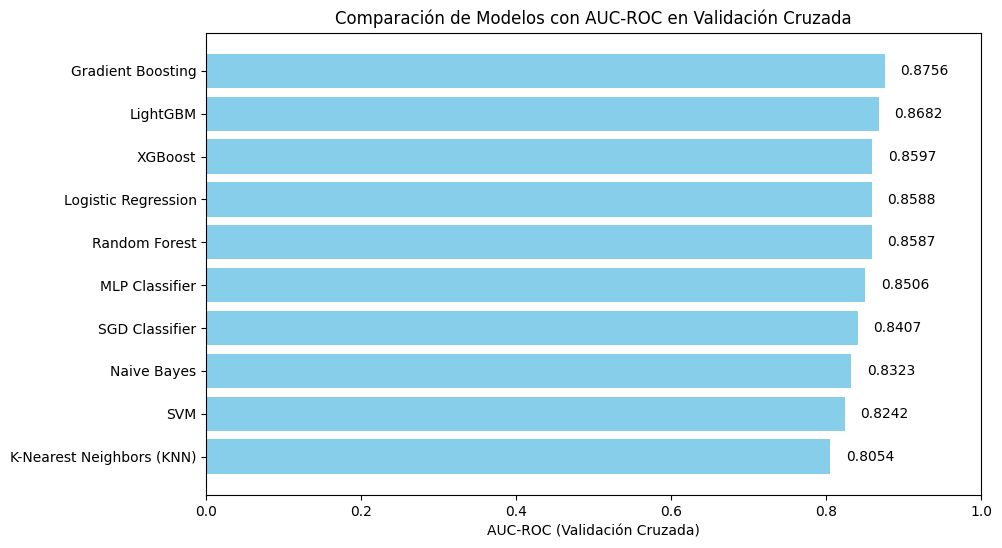

In [39]:
# Modelos de clasificación para comparación y selección de los más prometedores
models = {
    "Logistic Regression": LogisticRegression(solver='saga', max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),  # Necesitamos 'probability=True' para calcular ROC-AUC
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=0),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SGD Classifier": SGDClassifier(random_state=42)  # Añadido el modelo SGDClassifier
}

# Función para evaluar AUC-ROC, exactitud y validación cruzada
def evaluate_model(model, features_train_balanced_scaled, target_train_balanced, features_test_scaled, target_test):
    model.fit(features_train_balanced_scaled, target_train_balanced)
    
    if hasattr(model, "predict_proba"):  # Modelos con predict_proba
        y_pred_prob = model.predict_proba(features_test_scaled)[:, 1]
    else:  # Modelos sin predict_proba (como SVM)
        y_pred_prob = model.decision_function(features_test_scaled)
        
    y_pred = model.predict(features_test_scaled)  # Predicciones de clase
    
    auc_score = roc_auc_score(target_test, y_pred_prob)  # AUC-ROC
    accuracy = accuracy_score(target_test, y_pred)  # Exactitud
    
    # Validación cruzada para cada modelo
    cv_auc = cross_val_score(model, features_train_balanced_scaled, target_train_balanced, cv=5, scoring='roc_auc')
    cv_accuracy = cross_val_score(model, features_train_balanced_scaled, target_train_balanced, cv=5, scoring='accuracy')
    
    return auc_score, accuracy, np.mean(cv_auc), np.mean(cv_accuracy), model

# Comparamos los modelos
auc_scores = []
accuracy_scores = []
cv_auc_scores = []
cv_accuracy_scores = []

for model_name, model in models.items():
    auc_score, accuracy, mean_cv_auc, mean_cv_accuracy, trained_model = evaluate_model(
        model, features_train_balanced_scaled, target_train_balanced, features_test_scaled, target_test
    )
    auc_scores.append((model_name, auc_score))
    accuracy_scores.append((model_name, accuracy))
    cv_auc_scores.append((model_name, mean_cv_auc))
    cv_accuracy_scores.append((model_name, mean_cv_accuracy))
    
    #print(f'{model_name} - AUC: {auc_score:.4f} - Exactitud: {accuracy:.4f} - CV AUC: {mean_cv_auc:.4f} - CV Accuracy: {mean_cv_accuracy:.4f}')

# Creamos un DataFrame con los resultados
results_df = pd.DataFrame({
    'Model': [score[0] for score in auc_scores],  # Nombres de los modelos
    'AUC-ROC': [score[1] for score in auc_scores],  # Valores de AUC-ROC
    'Accuracy': [score[1] for score in accuracy_scores],  # Valores de Exactitud
    'CV AUC-ROC': [score[1] for score in cv_auc_scores],  # Resultados de AUC-ROC en validación cruzada
    'CV Accuracy': [score[1] for score in cv_accuracy_scores]  # Resultados de Exactitud en validación cruzada
})

# Ordenar por AUC-ROC en orden descendente
results_df = results_df.sort_values(by='CV AUC-ROC', ascending=False).reset_index(drop=True)

# Mostrar el DataFrame ordenado
print(results_df)

results_df = results_df.sort_values(by='CV AUC-ROC', ascending=True).reset_index()

# Gráfico de AUC-ROC ordenado
plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Model'], results_df['CV AUC-ROC'], color='skyblue')
plt.xlabel('AUC-ROC (Validación Cruzada)')
plt.title('Comparación de Modelos con AUC-ROC en Validación Cruzada')
plt.xlim(0, 1)

# Agregamos los valores de AUC-ROC al lado de las barras
for bar in bars:
    width = bar.get_width()  # El valor de AUC-ROC (longitud de la barra)
    plt.text(width + 0.02, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center')

plt.show()

Mejores parámetros encontrados: OrderedDict({'learning_rate': 0.03211478685986422, 'max_depth': 3, 'max_features': 0.2457286123772669, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 415, 'subsample': 0.5543790059937634})
Train AUC-ROC: 0.8971
Test AUC-ROC: 0.8641
Train Accuracy: 0.8453
Test Accuracy: 0.8105
Cross-Validation AUC-ROC (Entrenamiento): 0.88
Cross-Validation AUC-ROC (Prueba): 0.85


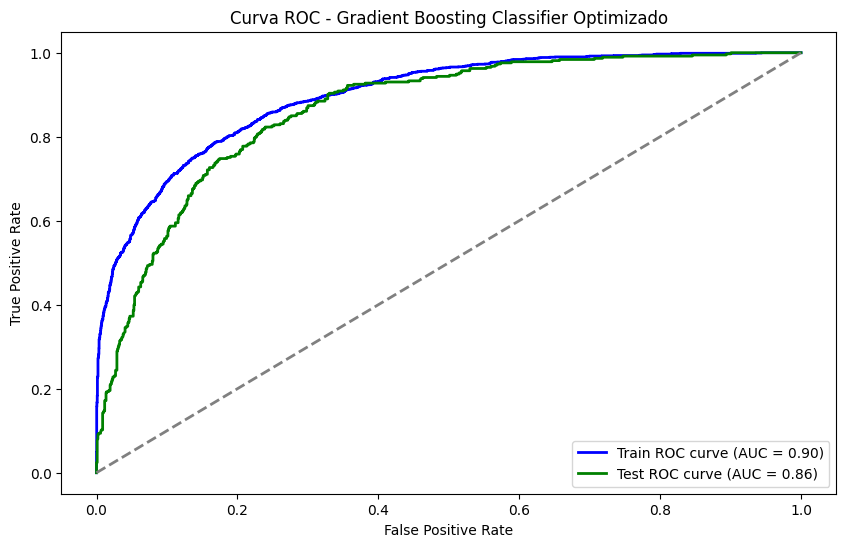

In [40]:
# Optimizacion de Gradient Boosting con BayessearchCV para lograr el mayor AUC-ROC con validacion cruzada

# Definir el rango de parámetros para optimizar el modelo
param_space = {
    'n_estimators': (50, 500),  # Número de árboles
    'learning_rate': (0.01, 0.2, 'uniform'),  # Tasa de aprendizaje
    'max_depth': (3, 5),  # Profundidad máxima de los árboles
    'min_samples_split': (2, 10),  # Mínimo número de muestras necesarias para dividir un nodo
    'min_samples_leaf': (1, 10),  # Mínimo número de muestras necesarias en un nodo hoja
    'subsample': (0.5, 1.0, 'uniform'),  # Fracción de muestras usadas para entrenar cada árbol
    'max_features': (0.1, 1.0, 'uniform')  # Fracción de características utilizadas en cada árbol
}

# Instanciamos el modelo GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

# Realizamos la optimización con BayesSearchCV
opt_gb = BayesSearchCV(gb_model, param_space, n_iter=50, cv=5, n_jobs=-1, verbose=0)

# Ajustamos el modelo optimizado sobre los datos de entrenamiento
opt_gb.fit(features_train_balanced_scaled, target_train_balanced)

# Establecemos el mejor modelo encontrado
best_model = opt_gb.best_estimator_
print("Mejores parámetros encontrados:", opt_gb.best_params_)

# Predicciones de probabilidad para AUC-ROC
y_train_pred_prob = best_model.predict_proba(features_train_balanced_scaled)[:, 1]
y_test_pred_prob = best_model.predict_proba(features_test_scaled)[:, 1]

# Predicciones de clase
y_train_pred = best_model.predict(features_train_balanced_scaled)
y_test_pred = best_model.predict(features_test_scaled)

# Calcular AUC-ROC y exactitud
train_auc_score = roc_auc_score(target_train_balanced, y_train_pred_prob)
test_auc_score = roc_auc_score(target_test, y_test_pred_prob)

train_accuracy = accuracy_score(target_train_balanced, y_train_pred)
test_accuracy = accuracy_score(target_test, y_test_pred)

print(f"Train AUC-ROC: {train_auc_score:.4f}")
print(f"Test AUC-ROC: {test_auc_score:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Validación cruzada para AUC-ROC sobre los datos de entrenamiento 
cv_auc_scores_train = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(features_train_balanced_scaled, target_train_balanced):
    X_train_fold, X_val_fold = features_train_balanced_scaled[train_idx], features_train_balanced_scaled[val_idx]
    y_train_fold, y_val_fold = target_train_balanced[train_idx], target_train_balanced[val_idx]
    
    # Ajustamos el modelo en cada pliegue
    best_model.fit(X_train_fold, y_train_fold)
    
    # Calculamos las probabilidades para la curva ROC
    y_val_pred_prob = best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculamos el AUC-ROC para este pliegue
    fold_auc = roc_auc_score(y_val_fold, y_val_pred_prob)
    cv_auc_scores_train.append(fold_auc)

# Promediamos el AUC-ROC de la validación cruzada en los datos de entrenamiento para tener una metrica mas robusta
mean_cv_auc_train = np.mean(cv_auc_scores_train)
print(f"Cross-Validation AUC-ROC (Entrenamiento): {mean_cv_auc_train:.2f}")

# Validación cruzada para AUC-ROC sobre los datos de prueba
cv_auc_scores_test = []

# Convertir target_test a un array NumPy
target_test_array = target_test.values

for train_idx, val_idx in cv.split(features_test_scaled, target_test_array):
    X_train_fold, X_val_fold = features_test_scaled[train_idx], features_test_scaled[val_idx]
    y_train_fold, y_val_fold = target_test_array[train_idx], target_test_array[val_idx]  # Aquí se usa el array

    # Ajustamos el modelo en cada pliegue
    best_model.fit(X_train_fold, y_train_fold)
    
    # Calculamos las probabilidades para la curva ROC
    y_val_pred_prob = best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculamos el AUC-ROC para este pliegue
    fold_auc = roc_auc_score(y_val_fold, y_val_pred_prob)
    cv_auc_scores_test.append(fold_auc)

# Promediamos el AUC-ROC de la validación cruzada en los datos de prueba
mean_cv_auc_test = np.mean(cv_auc_scores_test)
print(f"Cross-Validation AUC-ROC (Prueba): {mean_cv_auc_test:.2f}")

# Calculamos la Curva ROC
fpr_train, tpr_train, _ = roc_curve(target_train_balanced, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(target_test, y_test_pred_prob)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Graficamos la Curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Gradient Boosting Classifier Optimizado')
plt.legend(loc='lower right')
plt.show()


Conclusiones:

- Aplicamos el preprocesamiento de datos con limpieza, manipulacion e imputacion de datos y dejamos los datos oringinales listos para procesarlos
- Probamos diferentes modelos de clasificacion para identificar los mas prometedores con el fin de conseguir el mayor AUC-ROC posible, considerando una validacion cruzada.
- El mejor modelo con parametros basicos logro un 0.8756 como AUC_ROC con validacion cruzada y una exactitud de 0.8112.
- Optimizamos el modelos con mayor AUC-ROC, GradientBoosting
- Usamos BayesSearchCV para optimizar el modelo de GradientBoostingClassifier
- Con GradientBoosting optimizado tenemos un CV AUC_ROC de 0.88 y un Acuracy de 0.85 con datos de entrenamiento.
- - Con GradientBoosting optimizado tenemos un CV AUC_ROC de 0.85 y un Acuracy de 0.81 con datos de entrenamiento.